In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


I've made a small and naiive (and, probably, buggy) parser  
to convert symbolic constraints to the linear programming style matrix 

In [2]:
from utils import parse_constraints

In [3]:
constraints = """
  x <= 2
  x >= 0
  x + y >= 0
  y + 0.5 * x <= 2  
"""
variables = ['x','y']

In [4]:
A, B = parse_constraints(constraints, variables)
A, B = np.array([A[v] for v in variables]), np.array(B)

In [5]:
print(A)
print(B)

[[ 1.  -1.  -1.   0.5]
 [ 0.  -0.  -1.   1. ]]
[ 2. -0. -0.  2.]


Plot the region and the log-boundary function

In [6]:
XX, YY = np.meshgrid(*[np.linspace(-2,3,201)]*2)
rs = np.array([XX,YY])

rs = np.transpose(rs,axes=(1,2,0)).reshape((-1,2))

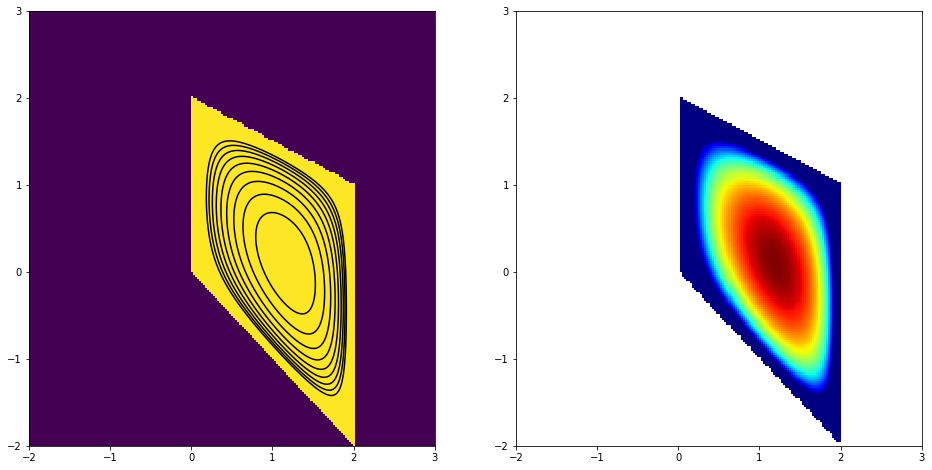

In [7]:
with np.errstate(invalid='ignore', divide='ignore'):
    F = np.log(B[:,None] - np.dot(A.T,rs.T)).sum(axis=0).reshape((201,201))

figsize(16,8)
subplot(121)
region = (np.dot(A.T,rs.T) <= B[:,None]).all(axis=0).reshape((201,201))
pcolor(XX,YY,region)
contour(XX,YY,F,levels=np.linspace(-1,F[np.isfinite(F)].max(),10), colors=['k']*10)
subplot(122)
pcolor(XX,YY,F,vmin=-1, cmap='jet')

Need good uniform random sampling from an ellipsoid

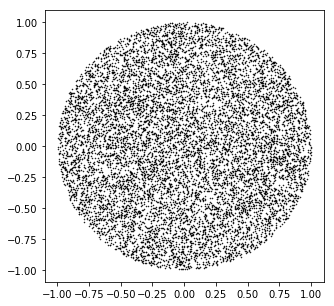

In [8]:
def random_circle():
    t = 2*np.pi*np.random.uniform()
    u = np.random.uniform() + np.random.uniform()
    r = 2 - u if u > 1 else u
    return np.array([r*cos(t), r*sin(t)])
random_circle()
figsize(5,5)
plot(*np.array([random_circle() for _ in range(10000)]).T, '.', lw=0, color='k', markersize=1 )

In [9]:
def random_ellipse(D):
    lamb, U = np.linalg.eig(D)
    r = random_circle()
    return np.dot(r/np.sqrt(lamb), U.T)

Testing on a dikin ellipsodi inside our region:

In [10]:
r = np.array([1.5,-1.0])
t = A[:,np.newaxis,:] * A[np.newaxis,:,:]
s = B - np.dot(A.T,r)
D = (t / s**2).sum(axis=-1)
D

array([[8.49382716, 4.09876543],
       [4.09876543, 4.19753086]])

(-1, 1)

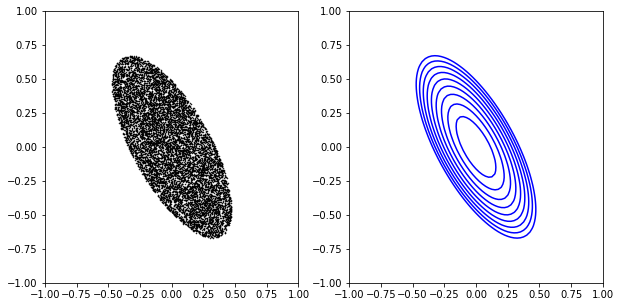

In [11]:
pts = np.array([random_ellipse(D) for _ in range(10000)])
ellip = (np.matmul(rs, D) * rs).sum(axis=1).reshape(XX.shape)

figsize(10,5)
subplot(121)
plot(*pts.T, '.', lw=0, color='k', markersize=1, zorder=1)
ylim(-1,1);xlim(-1,1)
subplot(122)
contour(XX,YY,ellip, levels=np.linspace(0,1,10),zorder=2,colors=['b']*10)
ylim(-1,1);xlim(-1,1)

Making a random walk inside the region

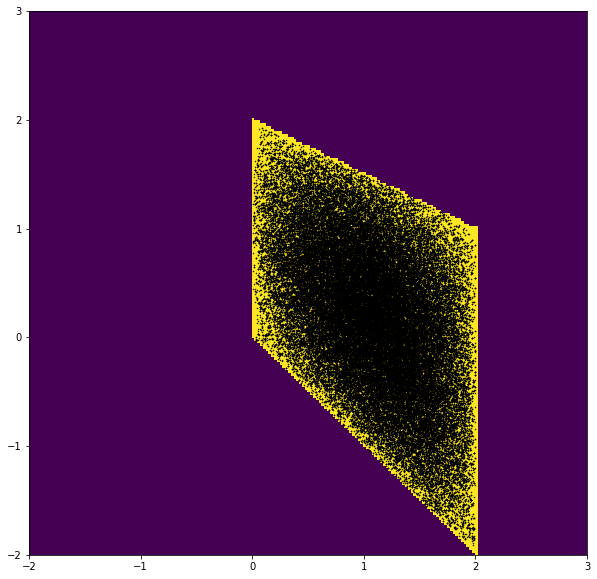

In [12]:
def dikin_ellipsoid(r,A,B):
    t = A[:,np.newaxis,:] * A[np.newaxis,:,:]
    s = B - np.dot(A.T,r)
    D = (t / s**2).sum(axis=-1)
    return D


walk = []

r = np.array([1.5,-1.0])
D = dikin_ellipsoid(r,A,B)

for _ in range(100000):
    rnew = r + 0.99*random_ellipse(D)
    if (np.dot(A.T,rnew) <= B).all():
        Dnew = dikin_ellipsoid(rnew,A,B)
        paccept = np.sqrt(np.linalg.det(D)/np.linalg.det(Dnew))
        #paccept = np.linalg.det(D)/np.linalg.det(Dnew)
        if np.random.uniform() < paccept:
            r,D = rnew, Dnew
    walk.append(r)

figsize(10,10)
pcolor(XX,YY,region)
plot(*np.array(walk).T, '.', lw=0,color='k', markersize=1, zorder=1)
